<a href="https://colab.research.google.com/github/pratikshaa12/Image-Classification-using-CNN/blob/main/Image_Classification3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementation of CNN for Image Classification with Advance Hyperparameter Tunning

In [2]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


### Step 1 - Importing necessary libraries

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras_tuner.tuners import RandomSearch
import matplotlib.pyplot as plt

### Step 2 - Loading and preprocessing the CIFAR-10 dataset

In [4]:
(train_images, train_labels), (test_images, test_labels)= datasets.cifar10.load_data()
train_images= train_images/255.0
test_images = test_images/255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Step 3 - Defining the class names for CIFAR-10

In [5]:
class_name= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Step 4 - Define a function to build the model

In [8]:
def build_model(hp):
  model=models.Sequential()

  # tune the number of Convolutional Layers (1,2 or 3)
  for i in range(hp.Int('conv_layers', 1, 3)):
    if i == 0:
      model.add(layers.Conv2D(
          filters=hp.Int('filters_' + str(i), min_value=32, max_value=128, step=16),
          kernel_size=(3,3),
          activation='relu',
          input_shape=(32,32,3)
      ))
    else:
      model.add(layers.Conv2D(
        filters= hp.Int('filters_' + str(i), min_value=32, max_value=128, step=16),
        kernel_size=(3,3),
        activation='relu',
        padding='same'))
      model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())

  # tune the numver of Dense layers(1,2 or 3)
  for i in range(hp.Int('dense_layers', 1, 3)):
     model.add(layers.Dense(
          units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=16),
          activation='relu'))

     # tune the droupout rate
     model.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5,step=0.1)))


     # the last Dense layer with 10 output units (for 10 classes of CIFAR-10 dataset)
     model.add(layers.Dense(10, activation='softmax'))

     # Choose an optimizer and learning rate
     optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
     model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
     return model


### Step 5 - Define the tuner

In [9]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory ='my_dir',
    project_name='cifar10_tunning'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Step 6 - Perform the Hyperparameter search

In [10]:
tuner.search(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

Trial 10 Complete [00h 00m 40s]
val_accuracy: 0.10320000350475311

Best val_accuracy So Far: 0.6092000007629395
Total elapsed time: 00h 06m 08s


### Step 7- Get the best Hyperparameters

In [11]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

### Step 8 - Build the model with the best Hyperparameters and train it

In [12]:
model= tuner.hypermodel.build(best_hps)
history= model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3848 - loss: 1.7218 - val_accuracy: 0.5516 - val_loss: 1.2643
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5657 - loss: 1.2102 - val_accuracy: 0.5827 - val_loss: 1.1835
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6375 - loss: 1.0210 - val_accuracy: 0.5756 - val_loss: 1.1763
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6917 - loss: 0.8649 - val_accuracy: 0.6049 - val_loss: 1.1347
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7375 - loss: 0.7355 - val_accuracy: 0.6028 - val_loss: 1.1902


### Step 9- Plotting training and validation accuracy and loss values

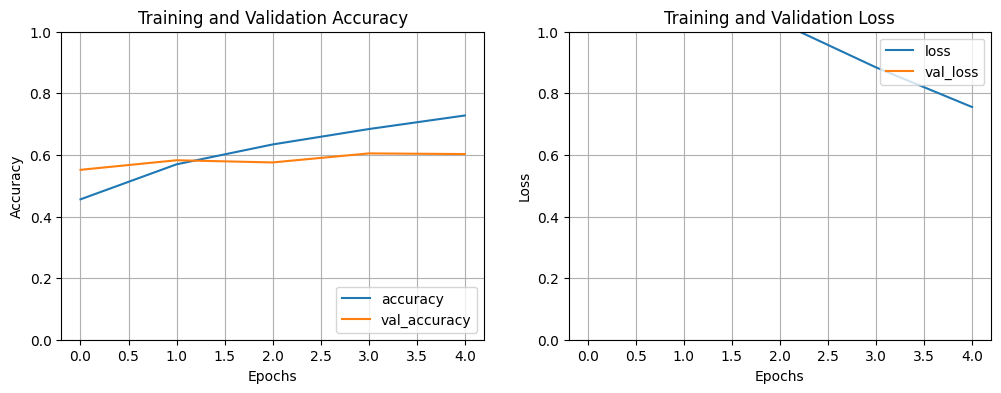

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.show()